In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import backend as K
import glob
import PIL
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
np.random.seed(101)

2023-03-20 12:13:49.726787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 12:13:49.938666: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-20 12:13:50.699635: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/cudnn-8.4/8.4/lib64:/cm/local/apps/cuda/libs/current/lib64:/cm/shared/apps/cuda11.2/toolkit/11.2.0/targets/x86_64-linux/lib:/cm/local/apps/gcc/7.2.0/lib:/cm/local/apps/gcc/7.2.0/lib64:/hom

# Data preprocessing

In [2]:
!git clone https://github.com/Shankar0x/Datasets.git imgs
from PIL import Image

fatal: destination path 'imgs' already exists and is not an empty directory.


X_train shape:  (200, 192, 256, 3)
Y_train shape:  (200, 192, 256)


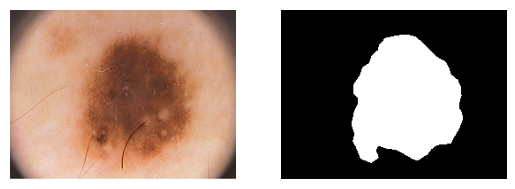

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts


filelist_trainx = sorted(glob.glob('imgs/Resized_Skin_Lesion_Dataset/Train_images/Trainx/*.bmp'), key=numericalSort)
x_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('imgs/Resized_Skin_Lesion_Dataset/Train_masks/Trainy/*.bmp'), key=numericalSort)
y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

# filelist_trainx = sorted(glob.glob('imgs/Electron_Microscopy_Dataset/images/*.tif'), key=numericalSort)
# x_train = np.array([np.array(Image.open(fname).convert('RGB')) for fname in filelist_trainx])

# filelist_trainy = sorted(glob.glob('imgs/Electron_Microscopy_Dataset/masks/*.tif'), key=numericalSort)
# y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

# filelist_trainx = sorted(glob.glob('imgs/Skin_Lesion_Dataset/trainx/*.jpg'), key=numericalSort)
# x_train = np.array([np.array(Image.open(fname).convert('RGB')) for fname in filelist_trainx])

# filelist_trainy = sorted(glob.glob('imgs/Skin_Lesion_Dataset/trainy/*.jpg'), key=numericalSort)
# y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])


print("X_train shape: ",x_train.shape)
print("Y_train shape: ",y_train.shape)
plt.subplot(1,2,1)
plt.imshow(x_train[0].astype('uint8'))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(y_train[0].astype('uint8'),cmap = plt.cm.binary_r)
plt.axis('off')
plt.show()

In [4]:
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.25,random_state=101)

In [5]:
print("X_train shape: ",x_train.shape)
print("Y_train shape: ",y_train.shape)
print("X_test shape: ",x_test.shape)
print("Y_test shape: ",y_test.shape)

X_train shape:  (150, 192, 256, 3)
Y_train shape:  (150, 192, 256)
X_test shape:  (50, 192, 256, 3)
Y_test shape:  (50, 192, 256)


In [6]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [7]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [8]:
def img_augmentation(x_test, y_test):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_test)):
        x,y = random_rotation(x_test[idx], y_test[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_test[idx], y_test[idx])
        x_flip.append(x)
        y_flip.append(y)

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [9]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = img_augmentation(x_test, y_test)

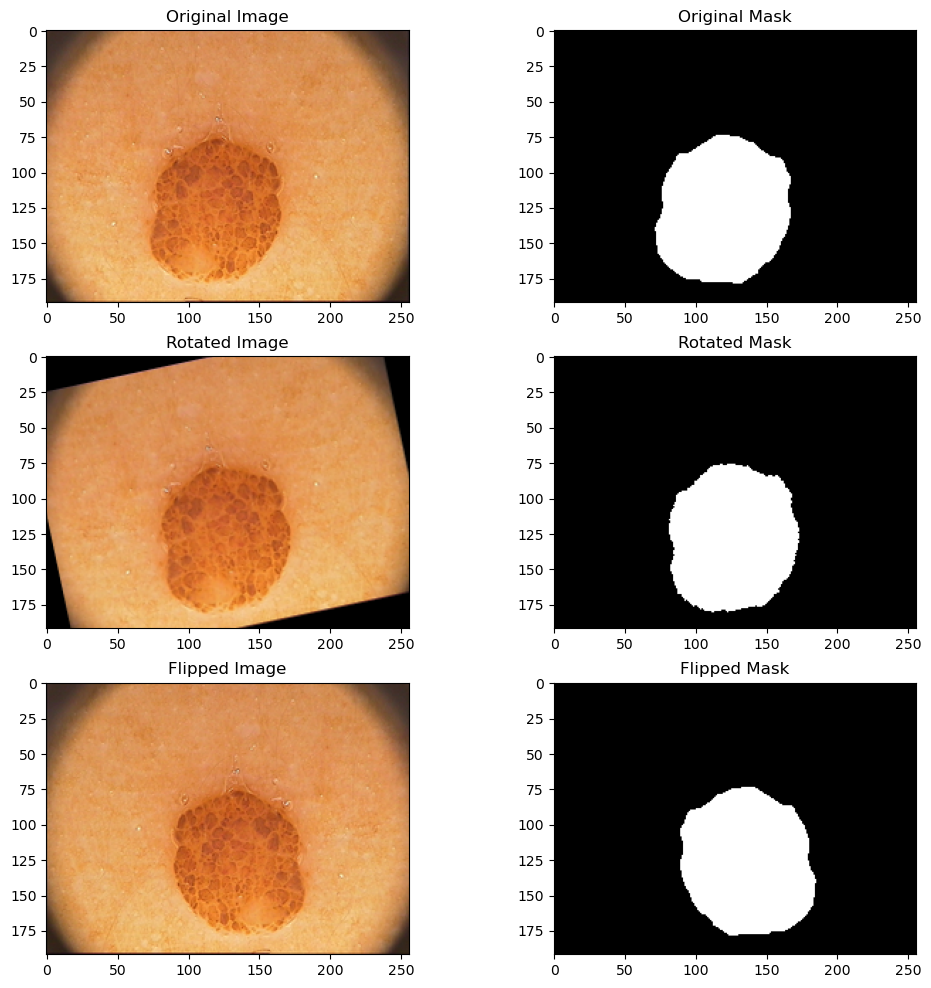

In [10]:
img_num = 114
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [11]:
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(360, 192, 256, 3)
(360, 192, 256)
(50, 192, 256, 3)
(50, 192, 256)
(90, 192, 256, 3)
(90, 192, 256)


# Accuracy of model

In [14]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

# Coding the model

In [15]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, SGD

In [16]:
def segnet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 2, validation_data= (x_val, y_val), verbose=1)
    
    model.save(savename)
    return model,hist

In [17]:
model, hist = segnet(100, 'segnet_100_epoch.h5')

2023-03-20 12:14:01.405757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 12:14:02.214948: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14625 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 192, 256, 64)      1792      
                                                                 
 bn1 (BatchNormalization)    (None, 192, 256, 64)      256       
                                                                 
 activation (Activation)     (None, 192, 256, 64)      0         
                                                                 
 conv2 (Conv2D)              (None, 192, 256, 64)      36928     
                                                                 
 bn2 (BatchNormalization)    (None, 192, 256, 64)      256       
                                                                 
 activation_1 (Activation)   (None, 192, 256, 64)      0     

 2D)                                                             
                                                                 
 deconv4 (Conv2DTranspose)   (None, 24, 32, 512)       2359808   
                                                                 
 bn17 (BatchNormalization)   (None, 24, 32, 512)       2048      
                                                                 
 activation_16 (Activation)  (None, 24, 32, 512)       0         
                                                                 
 deconv5 (Conv2DTranspose)   (None, 24, 32, 512)       2359808   
                                                                 
 bn18 (BatchNormalization)   (None, 24, 32, 512)       2048      
                                                                 
 activation_17 (Activation)  (None, 24, 32, 512)       0         
                                                                 
 deconv6 (Conv2DTranspose)   (None, 24, 32, 256)       1179904   
          

/home/ok_sikha/anaconda3/envs/tf_gpu_segnet/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100


2023-03-20 12:14:07.842462: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


180/180 [==============================] - 15s 46ms/step - loss: 0.4973 - accuracy: 0.8037 - val_loss: 0.5809 - val_accuracy: 0.6962
Epoch 2/100
180/180 [==============================] - 7s 41ms/step - loss: 0.3964 - accuracy: 0.8771 - val_loss: 0.3469 - val_accuracy: 0.8972
Epoch 3/100
180/180 [==============================] - 8s 42ms/step - loss: 0.3507 - accuracy: 0.8968 - val_loss: 0.3016 - val_accuracy: 0.9144
Epoch 4/100
180/180 [==============================] - 7s 40ms/step - loss: 0.3230 - accuracy: 0.9059 - val_loss: 0.2859 - val_accuracy: 0.9116
Epoch 5/100
180/180 [==============================] - 7s 41ms/step - loss: 0.3038 - accuracy: 0.9146 - val_loss: 0.2573 - val_accuracy: 0.9239
Epoch 6/100
180/180 [==============================] - 7s 41ms/step - loss: 0.2809 - accuracy: 0.9221 - val_loss: 0.2583 - val_accuracy: 0.9180
Epoch 7/100
180/180 [==============================] - 7s 41ms/step - loss: 0.2604 - accuracy: 0.9311 - val_loss: 0.2468 - val_accuracy: 0.9141
Epo

180/180 [==============================] - 7s 41ms/step - loss: 0.1123 - accuracy: 0.9769 - val_loss: 0.1509 - val_accuracy: 0.9472
Epoch 58/100
180/180 [==============================] - 7s 41ms/step - loss: 0.1070 - accuracy: 0.9775 - val_loss: 0.1518 - val_accuracy: 0.9474
Epoch 59/100
180/180 [==============================] - 7s 41ms/step - loss: 0.1135 - accuracy: 0.9774 - val_loss: 0.1528 - val_accuracy: 0.9464
Epoch 60/100
180/180 [==============================] - 8s 42ms/step - loss: 0.1022 - accuracy: 0.9795 - val_loss: 0.1533 - val_accuracy: 0.9448
Epoch 61/100
180/180 [==============================] - 8s 42ms/step - loss: 0.1010 - accuracy: 0.9792 - val_loss: 0.1506 - val_accuracy: 0.9472
Epoch 62/100
180/180 [==============================] - 7s 41ms/step - loss: 0.1008 - accuracy: 0.9793 - val_loss: 0.1542 - val_accuracy: 0.9447
Epoch 63/100
180/180 [==============================] - 7s 41ms/step - loss: 0.1085 - accuracy: 0.9785 - val_loss: 0.1487 - val_accuracy: 0.948

### Loading the model

In [23]:
model = keras.models.load_model('SegNet_Weights/SegNet_100ep_Skin_Lesions_bmp_file.h5')

### Getting a random prediction and it's IoU score

In [18]:
def enhance(img):
    sub = (model.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

1/1 [==============================] - 1s 1s/step


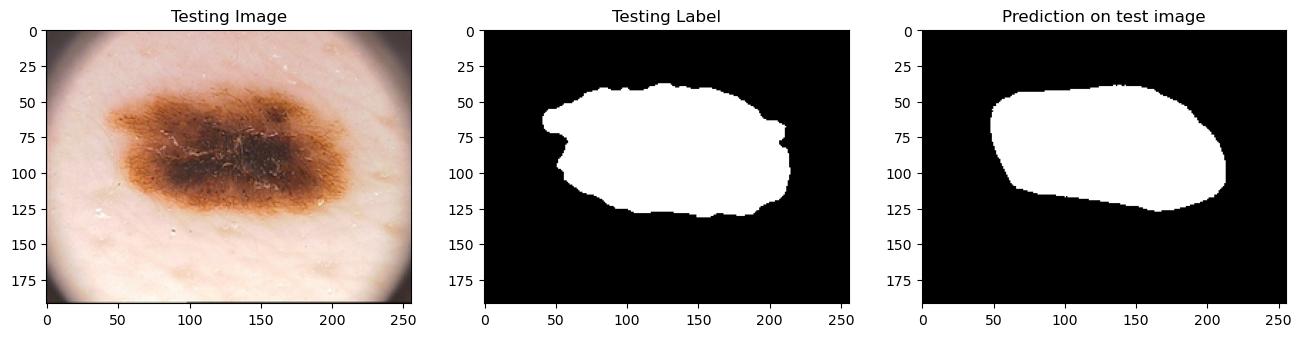

In [19]:
import random
test_img_number = random.randint(0, x_test.shape[0]-1)
test_img = x_test[test_img_number]
ground_truth=y_test[test_img_number]
prediction = enhance(test_img).reshape(192,256)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [20]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth, prediction)
print("IoU for the above prediction =", IOU_keras.result().numpy())

IoU for the above prediction = 0.91905314


In [21]:
sum_iou=0
for test_img_number in range(x_train_full.shape[0]):
    test_img = x_train_full[test_img_number]
    ground_truth=y_train_full[test_img_number]

    prediction = enhance(test_img).reshape(192,256)
    
    IOU_keras = MeanIoU(num_classes=n_classes)  
    IOU_keras.update_state(ground_truth, prediction)
    sum_iou+=IOU_keras.result().numpy()*100
    print("IoU for the current prediction =", IOU_keras.result().numpy())
print("Mean IoU: ",sum_iou/x_train_full.shape[0])

1/1 [==============================] - 0s 32ms/step
IoU for the current prediction = 0.9301665
1/1 [==============================] - 0s 31ms/step
IoU for the current prediction = 0.94336236
1/1 [==============================] - 0s 30ms/step
IoU for the current prediction = 0.8928322
1/1 [==============================] - 0s 29ms/step
IoU for the current prediction = 0.9512965
1/1 [==============================] - 0s 31ms/step
IoU for the current prediction = 0.62189925
1/1 [==============================] - 0s 30ms/step
IoU for the current prediction = 0.94803977
1/1 [==============================] - 0s 30ms/step
IoU for the current prediction = 0.94234425
1/1 [==============================] - 0s 30ms/step
IoU for the current prediction = 0.9658332
1/1 [==============================] - 0s 30ms/step
IoU for the current prediction = 0.88764143
1/1 [==============================] - 0s 30ms/step
IoU for the current prediction = 0.83989346
1/1 [==============================] - 0s 30

1/1 [==============================] - 0s 38ms/step
IoU for the current prediction = 0.8346827
1/1 [==============================] - 0s 52ms/step
IoU for the current prediction = 0.96031684
1/1 [==============================] - 0s 34ms/step
IoU for the current prediction = 0.9085511
1/1 [==============================] - 0s 43ms/step
IoU for the current prediction = 0.94624436
1/1 [==============================] - 0s 52ms/step
IoU for the current prediction = 0.9546298
1/1 [==============================] - 0s 60ms/step
IoU for the current prediction = 0.750738
1/1 [==============================] - 0s 67ms/step
IoU for the current prediction = 0.9113815
1/1 [==============================] - 0s 40ms/step
IoU for the current prediction = 0.97317505
1/1 [==============================] - 0s 65ms/step
IoU for the current prediction = 0.9099178
1/1 [==============================] - 0s 43ms/step
IoU for the current prediction = 0.7648921
1/1 [==============================] - 0s 51ms/s

1/1 [==============================] - 0s 33ms/step
IoU for the current prediction = 0.9578184
1/1 [==============================] - 0s 66ms/step
IoU for the current prediction = 0.96070635
1/1 [==============================] - 0s 30ms/step
IoU for the current prediction = 0.89843875
1/1 [==============================] - 0s 47ms/step
IoU for the current prediction = 0.8046543
1/1 [==============================] - 0s 43ms/step
IoU for the current prediction = 0.89463514
1/1 [==============================] - 0s 46ms/step
IoU for the current prediction = 0.93744755
1/1 [==============================] - 0s 71ms/step
IoU for the current prediction = 0.95819765
1/1 [==============================] - 0s 76ms/step
IoU for the current prediction = 0.94321084
1/1 [==============================] - 0s 40ms/step
IoU for the current prediction = 0.94893837
1/1 [==============================] - 0s 52ms/step
IoU for the current prediction = 0.9500768
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 61ms/step
IoU for the current prediction = 0.95140606
1/1 [==============================] - 0s 51ms/step
IoU for the current prediction = 0.8468808
1/1 [==============================] - 0s 71ms/step
IoU for the current prediction = 0.9522708
1/1 [==============================] - 0s 57ms/step
IoU for the current prediction = 0.9504621
1/1 [==============================] - 0s 39ms/step
IoU for the current prediction = 0.96379983
1/1 [==============================] - 0s 48ms/step
IoU for the current prediction = 0.9544687
1/1 [==============================] - 0s 50ms/step
IoU for the current prediction = 0.82937396
1/1 [==============================] - 0s 57ms/step
IoU for the current prediction = 0.94210535
1/1 [==============================] - 0s 68ms/step
IoU for the current prediction = 0.94251204
1/1 [==============================] - 0s 53ms/step
IoU for the current prediction = 0.87658393
1/1 [==============================] - 0s 72

1/1 [==============================] - 0s 81ms/step
IoU for the current prediction = 0.95824265
1/1 [==============================] - 0s 36ms/step
IoU for the current prediction = 0.950676
1/1 [==============================] - 0s 63ms/step
IoU for the current prediction = 0.9523608
1/1 [==============================] - 0s 73ms/step
IoU for the current prediction = 0.9691036
1/1 [==============================] - 0s 60ms/step
IoU for the current prediction = 0.9256834
1/1 [==============================] - 0s 45ms/step
IoU for the current prediction = 0.9374304
1/1 [==============================] - 0s 55ms/step
IoU for the current prediction = 0.9565167
1/1 [==============================] - 0s 71ms/step
IoU for the current prediction = 0.96926844
1/1 [==============================] - 0s 33ms/step
IoU for the current prediction = 0.930261
1/1 [==============================] - 0s 52ms/step
IoU for the current prediction = 0.72646636
1/1 [==============================] - 0s 63ms/st

1/1 [==============================] - 0s 41ms/step
IoU for the current prediction = 0.93783784
1/1 [==============================] - 0s 74ms/step
IoU for the current prediction = 0.94602877
1/1 [==============================] - 0s 53ms/step
IoU for the current prediction = 0.8620986
1/1 [==============================] - 0s 51ms/step
IoU for the current prediction = 0.93330365
1/1 [==============================] - 0s 67ms/step
IoU for the current prediction = 0.9407327
1/1 [==============================] - 0s 53ms/step
IoU for the current prediction = 0.8824183
1/1 [==============================] - 0s 72ms/step
IoU for the current prediction = 0.9497626
1/1 [==============================] - 0s 58ms/step
IoU for the current prediction = 0.9450015
1/1 [==============================] - 0s 60ms/step
IoU for the current prediction = 0.9442183
1/1 [==============================] - 0s 67ms/step
IoU for the current prediction = 0.9514006
1/1 [==============================] - 0s 69ms/

### Adding Skip Connections

In [22]:
from keras.layers import concatenate
def segnet_w_skip(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    drop_1 = x
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    drop_2 = x

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = concatenate([drop_2,x], axis = 3)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = concatenate([drop_1,x], axis = 3)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 2, validation_data= (x_val, y_val), verbose=1)
    
    model.save(savename)
    return model,hist

In [23]:
model, hist = segnet_w_skip(100, 'segnet_w_skip_100_epoch.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 192, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormalization)       (None, 192, 256, 64  256         ['conv1[0][0]']                  
                                )                                                           

                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 12, 16, 512)  0          ['activation_35[0][0]']          
                                                                                                  
 conv11 (Conv2D)                (None, 12, 16, 512)  2359808     ['max_pooling2d_8[0][0]']        
                                                                                                  
 bn11 (BatchNormalization)      (None, 12, 16, 512)  2048        ['conv11[0][0]']                 
                                                                                                  
 activation_36 (Activation)     (None, 12, 16, 512)  0           ['bn11[0][0]']                   
                                                                                                  
 conv12 (Conv2D)                (None, 12, 16, 512)  2359808     ['activation_36[0][0]']          
          

                                                                                                  
 bn22 (BatchNormalization)      (None, 48, 64, 128)  512         ['deconv9[0][0]']                
                                                                                                  
 activation_47 (Activation)     (None, 48, 64, 128)  0           ['bn22[0][0]']                   
                                                                                                  
 concatenate (Concatenate)      (None, 48, 64, 256)  0           ['max_pooling2d_6[0][0]',        
                                                                  'activation_47[0][0]']          
                                                                                                  
 up_sampling2d_8 (UpSampling2D)  (None, 96, 128, 256  0          ['concatenate[0][0]']            
                                )                                                                 
          

180/180 [==============================] - 8s 44ms/step - loss: 0.1819 - accuracy: 0.9542 - val_loss: 0.1873 - val_accuracy: 0.9488
Epoch 23/100
180/180 [==============================] - 8s 43ms/step - loss: 0.1921 - accuracy: 0.9491 - val_loss: 0.1566 - val_accuracy: 0.9537
Epoch 24/100
180/180 [==============================] - 8s 43ms/step - loss: 0.1787 - accuracy: 0.9550 - val_loss: 0.1808 - val_accuracy: 0.9419
Epoch 25/100
180/180 [==============================] - 8s 44ms/step - loss: 0.1801 - accuracy: 0.9532 - val_loss: 0.1786 - val_accuracy: 0.9466
Epoch 26/100
180/180 [==============================] - 8s 43ms/step - loss: 0.1750 - accuracy: 0.9559 - val_loss: 0.1673 - val_accuracy: 0.9483
Epoch 27/100
180/180 [==============================] - 8s 43ms/step - loss: 0.1750 - accuracy: 0.9552 - val_loss: 0.1802 - val_accuracy: 0.9444
Epoch 28/100
180/180 [==============================] - 8s 43ms/step - loss: 0.1647 - accuracy: 0.9594 - val_loss: 0.1695 - val_accuracy: 0.949

180/180 [==============================] - 8s 43ms/step - loss: 0.1033 - accuracy: 0.9782 - val_loss: 0.1299 - val_accuracy: 0.9570
Epoch 79/100
180/180 [==============================] - 8s 43ms/step - loss: 0.1070 - accuracy: 0.9788 - val_loss: 0.1343 - val_accuracy: 0.9556
Epoch 80/100
180/180 [==============================] - 8s 43ms/step - loss: 0.1097 - accuracy: 0.9766 - val_loss: 0.1331 - val_accuracy: 0.9562
Epoch 81/100
180/180 [==============================] - 8s 45ms/step - loss: 0.0997 - accuracy: 0.9795 - val_loss: 0.1323 - val_accuracy: 0.9566
Epoch 82/100
180/180 [==============================] - 8s 44ms/step - loss: 0.1103 - accuracy: 0.9764 - val_loss: 0.1335 - val_accuracy: 0.9558
Epoch 83/100
180/180 [==============================] - 8s 45ms/step - loss: 0.1004 - accuracy: 0.9797 - val_loss: 0.1321 - val_accuracy: 0.9560
Epoch 84/100
180/180 [==============================] - 8s 44ms/step - loss: 0.1002 - accuracy: 0.9793 - val_loss: 0.1320 - val_accuracy: 0.956

### Getting a random prediction and it's IoU score

In [24]:
def enhance(img):
    sub = (model.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

1/1 [==============================] - 1s 1s/step


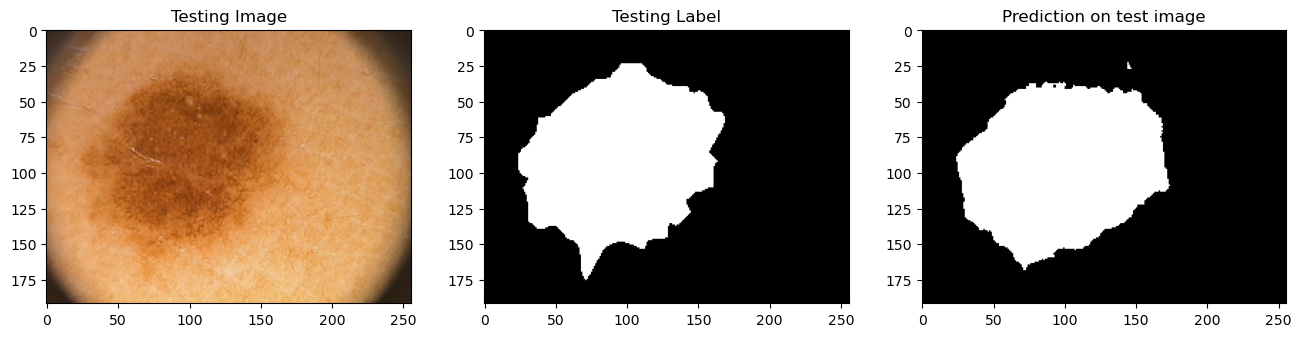

In [25]:
import random
test_img_number = random.randint(0, x_test.shape[0]-1)
test_img = x_test[test_img_number]
ground_truth=y_test[test_img_number]
prediction = enhance(test_img).reshape(192,256)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [26]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth, prediction)
print("IoU for the above prediction =", IOU_keras.result().numpy())

IoU for the above prediction = 0.9078463


In [27]:
sum_iou=0
for test_img_number in range(x_train_full.shape[0]):
    test_img = x_train_full[test_img_number]
    ground_truth=y_train_full[test_img_number]

    prediction = enhance(test_img).reshape(192,256)
    
    IOU_keras = MeanIoU(num_classes=n_classes)  
    IOU_keras.update_state(ground_truth, prediction)
    sum_iou+=IOU_keras.result().numpy()*100
    print("IoU for the current prediction =", IOU_keras.result().numpy())
print("Mean IoU: ",sum_iou/x_train_full.shape[0])

1/1 [==============================] - 0s 51ms/step
IoU for the current prediction = 0.9081342
1/1 [==============================] - 0s 47ms/step
IoU for the current prediction = 0.95354617
1/1 [==============================] - 0s 65ms/step
IoU for the current prediction = 0.9195496
1/1 [==============================] - 0s 53ms/step
IoU for the current prediction = 0.9670862
1/1 [==============================] - 0s 55ms/step
IoU for the current prediction = 0.6704767
1/1 [==============================] - 0s 48ms/step
IoU for the current prediction = 0.94880223
1/1 [==============================] - 0s 40ms/step
IoU for the current prediction = 0.9572781
1/1 [==============================] - 0s 64ms/step
IoU for the current prediction = 0.94172126
1/1 [==============================] - 0s 58ms/step
IoU for the current prediction = 0.8885815
1/1 [==============================] - 0s 63ms/step
IoU for the current prediction = 0.69873166
1/1 [==============================] - 0s 47ms

1/1 [==============================] - 0s 58ms/step
IoU for the current prediction = 0.93930614
1/1 [==============================] - 0s 44ms/step
IoU for the current prediction = 0.9331075
1/1 [==============================] - 0s 55ms/step
IoU for the current prediction = 0.9671622
1/1 [==============================] - 0s 49ms/step
IoU for the current prediction = 0.9463506
1/1 [==============================] - 0s 63ms/step
IoU for the current prediction = 0.92259216
1/1 [==============================] - 0s 48ms/step
IoU for the current prediction = 0.8277682
1/1 [==============================] - 0s 49ms/step
IoU for the current prediction = 0.7815194
1/1 [==============================] - 0s 68ms/step
IoU for the current prediction = 0.9695672
1/1 [==============================] - 0s 67ms/step
IoU for the current prediction = 0.861791
1/1 [==============================] - 0s 63ms/step
IoU for the current prediction = 0.47341275
1/1 [==============================] - 0s 75ms/s

1/1 [==============================] - 0s 70ms/step
IoU for the current prediction = 0.9135806
1/1 [==============================] - 0s 59ms/step
IoU for the current prediction = 0.9683255
1/1 [==============================] - 0s 69ms/step
IoU for the current prediction = 0.8398709
1/1 [==============================] - 0s 34ms/step
IoU for the current prediction = 0.85121655
1/1 [==============================] - 0s 38ms/step
IoU for the current prediction = 0.8824128
1/1 [==============================] - 0s 47ms/step
IoU for the current prediction = 0.9645392
1/1 [==============================] - 0s 75ms/step
IoU for the current prediction = 0.96327305
1/1 [==============================] - 0s 36ms/step
IoU for the current prediction = 0.9491119
1/1 [==============================] - 0s 37ms/step
IoU for the current prediction = 0.9679852
1/1 [==============================] - 0s 67ms/step
IoU for the current prediction = 0.9356606
1/1 [==============================] - 0s 37ms/s

1/1 [==============================] - 0s 50ms/step
IoU for the current prediction = 0.96625245
1/1 [==============================] - 0s 55ms/step
IoU for the current prediction = 0.8112509
1/1 [==============================] - 0s 69ms/step
IoU for the current prediction = 0.9647274
1/1 [==============================] - 0s 60ms/step
IoU for the current prediction = 0.9643618
1/1 [==============================] - 0s 61ms/step
IoU for the current prediction = 0.96848387
1/1 [==============================] - 0s 49ms/step
IoU for the current prediction = 0.92889845
1/1 [==============================] - 0s 56ms/step
IoU for the current prediction = 0.92542934
1/1 [==============================] - 0s 61ms/step
IoU for the current prediction = 0.9539103
1/1 [==============================] - 0s 76ms/step
IoU for the current prediction = 0.9624419
1/1 [==============================] - 0s 57ms/step
IoU for the current prediction = 0.8703158
1/1 [==============================] - 0s 71ms

1/1 [==============================] - 0s 50ms/step
IoU for the current prediction = 0.95039976
1/1 [==============================] - 0s 50ms/step
IoU for the current prediction = 0.96256167
1/1 [==============================] - 0s 57ms/step
IoU for the current prediction = 0.9525781
1/1 [==============================] - 0s 62ms/step
IoU for the current prediction = 0.9577242
1/1 [==============================] - 0s 64ms/step
IoU for the current prediction = 0.9505542
1/1 [==============================] - 0s 62ms/step
IoU for the current prediction = 0.92458344
1/1 [==============================] - 0s 51ms/step
IoU for the current prediction = 0.9675555
1/1 [==============================] - 0s 50ms/step
IoU for the current prediction = 0.9644442
1/1 [==============================] - 0s 68ms/step
IoU for the current prediction = 0.9660207
1/1 [==============================] - 0s 66ms/step
IoU for the current prediction = 0.89009833
1/1 [==============================] - 0s 48ms

1/1 [==============================] - 0s 60ms/step
IoU for the current prediction = 0.9536109
1/1 [==============================] - 0s 44ms/step
IoU for the current prediction = 0.89160323
1/1 [==============================] - 0s 43ms/step
IoU for the current prediction = 0.9025962
1/1 [==============================] - 0s 68ms/step
IoU for the current prediction = 0.96626
1/1 [==============================] - 0s 49ms/step
IoU for the current prediction = 0.95304775
1/1 [==============================] - 0s 50ms/step
IoU for the current prediction = 0.88692796
1/1 [==============================] - 0s 59ms/step
IoU for the current prediction = 0.9555468
1/1 [==============================] - 0s 65ms/step
IoU for the current prediction = 0.9413179
1/1 [==============================] - 0s 51ms/step
IoU for the current prediction = 0.85155106
1/1 [==============================] - 0s 46ms/step
IoU for the current prediction = 0.9217671
1/1 [==============================] - 0s 49ms/s